# Fast Image Processing with MXNet

Previous tutorials have shown two ways of preprocessing images:
- `mx.io.ImageRecordIter` is fast but inflexible. It is great for simple tasks like image recognition but won't work for more complex tasks like detection and segmentation.
- `mx.recordio.unpack_img` (or `cv2.imread`, `skimage`, etc) + `numpy` is flexible but slow. The root of the problem is python's Global Interpreter Lock (GIL). GIL is a complicated topic but the gist is python doesn't really support multi-threading; even if you spawn multiple threads execution will still be serialized. You can workaround it with multi-processing and message passing, but it's hard to program and introduces overhead.

To solve this issue, MXNet provides `mx.image` package. It stores images in [mx.nd.NDArray](./ndarray.ipynb) format and leverages MXNet's [dependency engine](http://mxnet.io/architecture/note_engine.html) to automatically parallelize image processing and circumvent GIL.

Please read [Intro to NDArray](./ndarray.ipynb) first if you are not familar with it.

Setup environment:

In [7]:
%matplotlib inline
from __future__ import print_function
import os
import time
# set the number of threads you want to use before importing mxnet
os.environ['MXNET_CPU_WORKER_NTHREADS'] = '4'
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
# download example images
os.system('wget http://data.mxnet.io/data/test_images.tar.gz')
os.system('tar -xf test_images.tar.gz')

0

## Image Loading
First we load images with mx.image.imdecode. The interface is very similar to opencv. But everything runs in parallel.

We also compare performance agains opencv. You can restart the kernel and change MXNET_CPU_WORKER_NTHREADS to see the performance improvement as more threads are used.

263.867350651 images decoded per second with opencv


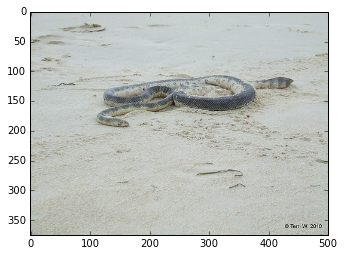

In [9]:
# opencv
N = 1000
tic = time.time()
for i in range(N):
    img = cv2.imread('test_images/ILSVRC2012_val_00000001.JPEG', flags=1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(N/(time.time()-tic), 'images decoded per second with opencv')
plt.imshow(img); plt.show()

951.311962346 images decoded per second with mx.image


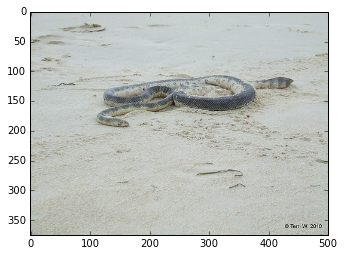

In [10]:
# mx.image
tic = time.time()
for i in range(N):
    img = mx.image.imdecode(open('test_images/ILSVRC2012_val_00000001.JPEG','rb').read())
mx.nd.waitall()
print(N/(time.time()-tic), 'images decoded per second with mx.image')
plt.imshow(img.asnumpy()); plt.show()

## Image Transformations

Once images are loaded as NDArray, you can then use `mx.nd.*` operators to transform them. mx.image provides utility functions for some typical transformations:

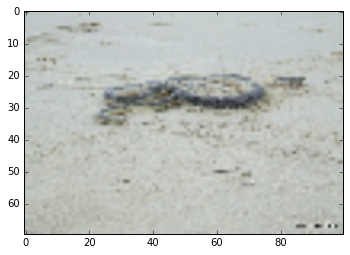

In [15]:
# resize to w x h
tmp = mx.image.imresize(img, 100, 70)
plt.imshow(tmp.asnumpy()); plt.show()

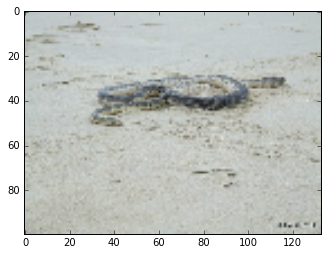

In [16]:
# resize shorter edge to size while preserving aspect ratio
tmp = mx.image.resize_short(img, 100)
plt.imshow(tmp.asnumpy()); plt.show()

(267, 141, 150, 200)


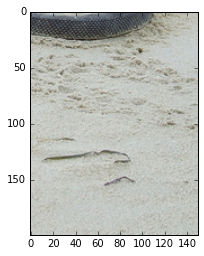

In [22]:
# crop a random w x h region from image
tmp, coord = mx.image.random_crop(img, (150, 200))
print(coord)
plt.imshow(tmp.asnumpy()); plt.show()

Other utility functions include `fixed_crop`, `center_crop`, `color_normalize`, and `random_size_crop`.

## ImageIter

Given the above functionalities, it's easy to write a custom data iterator. As an example, we provide `mx.image.ImageIter`, which is similar to Torch's [resnet](https://github.com/facebook/fb.resnet.torch/blob/master/dataloader.lua) image loading pipeline. For more details, please see `mxnet/python/mxnet/image.py`.